In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
from scipy.stats import gaussian_kde

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
#import torchvisionorchbearer
#from torchvision import transforms
from torch.utils.data import TensorDataset, DataLoader, random_split

import torchbearer
from torchbearer import Trial, metrics, Metric
from torchbearer.callbacks import Best, ModelCheckpoint

from tqdm import tqdm
import umap
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import warnings
warnings.filterwarnings("ignore")

2023-07-03 14:12:44.265947: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-03 14:12:52.079853: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# test gpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [7]:
# upload cell_by_gene file
mARN_df = pd.read_csv('~/Documents/Vu/AI/HumanOvarianCancerPatient2Slice2_cell_by_gene.csv')
#mARN_df.drop('cell', inplace=True, axis=1)
mARN_df

,cell,PDK4,CCL26,CX3CL1,CD4,SNAI2,TNFRSF17,ICAM3,TBX21,FAP,...,Blank-20,Blank-31,Blank-34,CXCR5,IL21,Blank-17,Blank-29,Blank-32,Blank-46,Blank-24
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71376,71376,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
71377,71377,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
71378,71378,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
71379,71379,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
# preprocessing data
class MyDataset(Dataset):
    """Apples Dataset"""

    def __init__(self, X, y=None, test=False):
        """
        Args:
        """
        self.test = test
        self.data = X
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        dat = self.data[idx]
        if self.test:
            return dat
        else:
            return [dat, dat]
        

In [30]:
# prepare the data (train, validation, test) for the model
tensor = torch.Tensor(mARN_df.values[:, 1:])

dataset = MyDataset(tensor)
train_size = int(0.7 * len(dataset))  # 80% dataset for training
val_size = int(0.15 * len(dataset))  # 10% dataset for validation
test_size = len(dataset) - train_size - val_size  # 10% dataset for test
X_train, X_val, X_test = random_split(dataset, [train_size, val_size, test_size])

train_dataloader = DataLoader(X_train, batch_size=64, shuffle=True)
val_dataloader = DataLoader(X_val, batch_size=32, shuffle=False)
test_dataloader = DataLoader(X_test, batch_size=32, shuffle=False)

In [31]:
# structure of the auto encoder model
class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(550, 250),
            nn.ReLU(),
            nn.Linear(250, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 10)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(10, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 250),
            nn.ReLU(),
            nn.Linear(250, 550),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [32]:
# define the parameters of train function
model = AutoEncoder()

check_last = ModelCheckpoint('check_last.pth')
checkpoint = Best('check_best.pth', monitor='val_loss', mode='min')

trial = Trial(model,
              optim.Adam(model.parameters(), lr=5e-04), 
              nn.CrossEntropyLoss(), 
              metrics=["loss"],
              callbacks=[check_last, checkpoint])

In [33]:
# train the model
trial = trial.load_state_dict(state_dict=torch.load("check_last.pth"))

trial.with_generators(train_generator=train_dataloader, 
                  val_generator=val_dataloader, 
                  test_generator=test_dataloader)


mytrial = trial.run(epochs=60, verbose=1)

100%|##########| 60/60 [00:00<?, ?it/s]

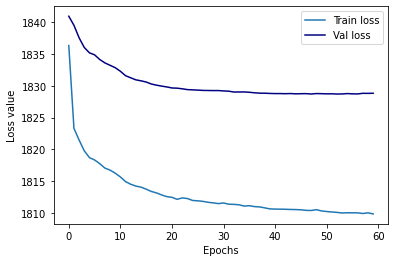

In [35]:
# plot the train loss and validation loss
plt.plot([mt["loss"] for mt in mytrial], label="Train loss", color="C0")
plt.plot([mt["val_loss"] for mt in mytrial], label="Val loss", color="navy")
plt.xlabel("Epochs")
plt.ylabel("Loss value")
plt.legend()
plt.show()

In [36]:
print(len(test_dataloader))
len(test_dataloader.dataset)

335


10708

In [37]:
print(len(train_dataloader))
print(test_dataloader.dataset)
len(train_dataloader.dataset)

781


49966

In [38]:
# encoder with test dataset
encoded_data = []

for i in tqdm(range(len(test_dataloader.dataset))):
    with torch.no_grad():
        sample = test_dataloader.dataset[i][0].unsqueeze(0)
        encoded_data.append(trial.state['model'].encoder.forward(sample).numpy()[0])

encoded_data = np.array(encoded_data)
print(encoded_data.shape)
encoded_data

100%|███████████████████████████████████| 10708/10708 [00:01<00:00, 8440.27it/s]


(10708, 10)


array([[ 3.9902692e+00, -2.9477973e+00, -6.7413797e+00, ...,
         2.6122165e+00,  2.1293845e+00,  2.7147827e+00],
       [ 2.8110030e-01, -1.0141104e-02, -6.3009152e+00, ...,
         1.2533796e+00, -7.7496080e+00, -7.8201485e+00],
       [ 3.9444712e-01, -2.7929023e-01, -3.1603113e-01, ...,
         3.0126119e+00, -1.9473561e+00, -5.9103179e+00],
       ...,
       [ 2.9553084e+00, -4.2453265e+00, -3.9452477e+00, ...,
        -3.0748200e+00, -1.5051807e+00,  4.5457835e+00],
       [-4.3778148e+00,  4.6792197e+00,  1.2594090e+00, ...,
        -8.2058471e-01,  8.1673651e+00,  8.5492811e+00],
       [ 2.6300149e+00, -2.7934663e+00, -3.1901686e+00, ...,
        -9.4108963e+00,  6.9942613e+00,  1.2918738e+01]], dtype=float32)

In [39]:
encoded_data.shape

(10708, 10)

In [40]:
len(X_test)

10708

In [41]:
reducer = umap.UMAP(random_state=42)
coordsUMAP = reducer.fit_transform(np.array(encoded_data))

In [42]:
# PCA method
pca = PCA(n_components=2)
coordsPCA = pca.fit_transform(encoded_data)

In [43]:
encoded_data.shape

(10708, 10)

In [44]:
# PCA method
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
coordsTSNE = tsne.fit_transform(encoded_data)

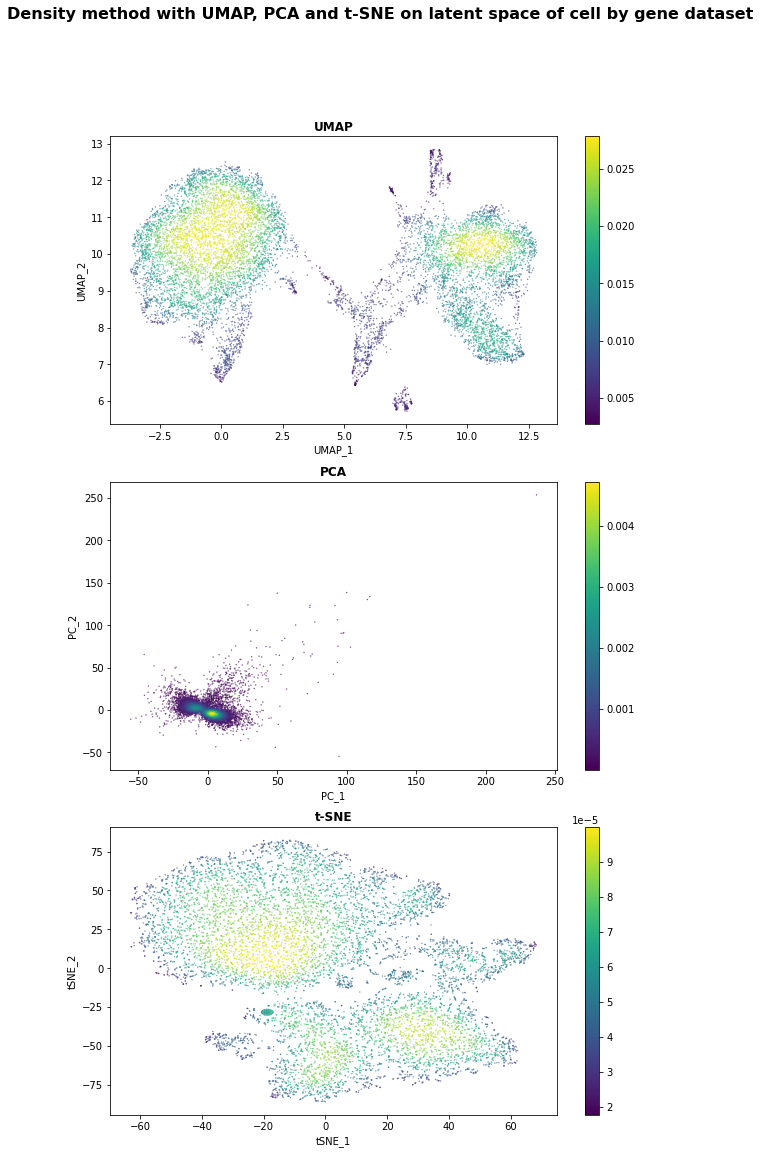

In [45]:
kde = gaussian_kde(coordsUMAP.T)
density_umap = kde(coordsUMAP.T)
kde = gaussian_kde(coordsPCA.T)
density_pca = kde(coordsPCA.T)
kde = gaussian_kde(coordsTSNE.T)
density_tsne = kde(coordsTSNE.T)

fig, axes = plt.subplots(3,1, figsize=(10,18))
fig.suptitle('Density method with UMAP, PCA and t-SNE on latent space of cell by gene dataset', fontsize=16, fontweight="bold")
axes[0].set_title("UMAP", fontweight="bold")
scatter_umap = axes[0].scatter(coordsUMAP[:,0], coordsUMAP[:,1], c=density_umap, cmap='viridis', s=0.1)
fig.colorbar(scatter_umap, ax=axes[0])
axes[0].set_xlabel("UMAP_1")
axes[0].set_ylabel("UMAP_2")

axes[1].set_title("PCA", fontweight="bold")
scatter_pca = axes[1].scatter(coordsPCA[:, 0], coordsPCA[:, 1], c=density_pca, cmap='viridis', s=0.1)
fig.colorbar(scatter_pca, ax=axes[1])
axes[1].set_xlabel("PC_1")
axes[1].set_ylabel("PC_2")

axes[2].set_title("t-SNE", fontweight="bold")
scatter_tsne = axes[2].scatter(coordsTSNE[:, 0], coordsTSNE[:, 1], c=density_tsne, cmap='viridis', s=0.1)
fig.colorbar(scatter_tsne, ax=axes[2])
axes[2].set_xlabel("tSNE_1")
axes[2].set_ylabel("tSNE_2")

plt.show()

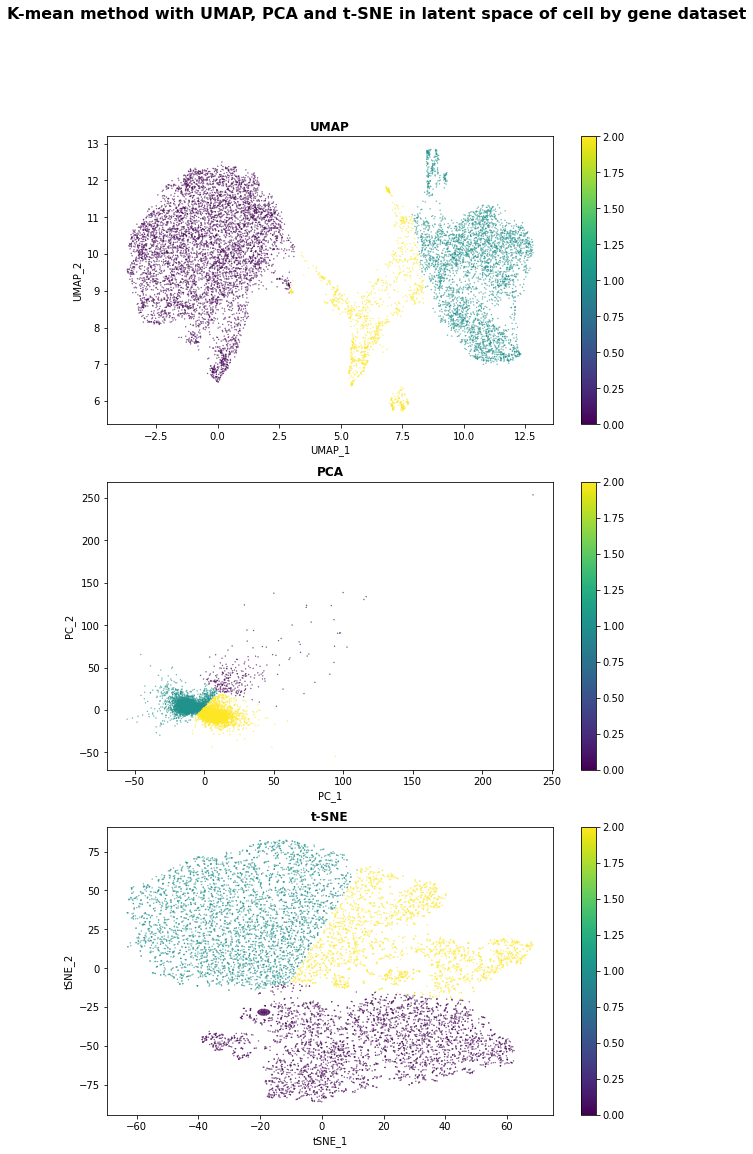

In [46]:
k = 3
kmeans = KMeans(n_clusters=k)
labels_UMAP = kmeans.fit_predict(coordsUMAP)
labels_PCA = kmeans.fit_predict(coordsPCA)
labels_TSNE = kmeans.fit_predict(coordsTSNE)


fig, axes = plt.subplots(3,1, figsize=(10,18))
fig.suptitle('K-mean method with UMAP, PCA and t-SNE in latent space of cell by gene dataset', fontsize=16, fontweight="bold")

axes[0].set_title("UMAP", fontweight="bold")
scatter_umap = axes[0].scatter(coordsUMAP[:,0], coordsUMAP[:,1], c=labels_UMAP, cmap='viridis', s=0.1)
fig.colorbar(scatter_umap, ax=axes[0])
axes[0].set_xlabel("UMAP_1")
axes[0].set_ylabel("UMAP_2")

axes[1].set_title("PCA", fontweight="bold")
scatter_pca = axes[1].scatter(coordsPCA[:, 0], coordsPCA[:, 1], c=labels_PCA, cmap='viridis', s=0.1)
fig.colorbar(scatter_pca, ax=axes[1])
axes[1].set_xlabel("PC_1")
axes[1].set_ylabel("PC_2")

axes[2].set_title("t-SNE", fontweight="bold")
scatter_tsne = axes[2].scatter(coordsTSNE[:, 0], coordsTSNE[:, 1], c=labels_TSNE, cmap='viridis', s=0.1)
fig.colorbar(scatter_tsne, ax=axes[2])
axes[2].set_xlabel("tSNE_1")
axes[2].set_ylabel("tSNE_2")

plt.show()

In [47]:
max_PKM = mARN_df['PKM'].max()
mean_PKM = mARN_df['PKM'].mean()
print(max_PKM)
mean_PKM

394.0


22.525461957663804

In [48]:
genes_chosen_df = pd.read_csv('~/Documents/Vu/AI/HumanOvarianCancerPatient2Slice2_cell_by_gene.csv')
list_genes_chosen = ['cell', 'PKM']

for i, gene in enumerate(genes_chosen_df.columns[:]):
    if gene not in list_genes_chosen:
        genes_chosen_df.drop(gene, inplace=True, axis=1)

genes_chosen_df

,cell,PKM
0,0,0.0
1,1,0.0
2,2,2.0
3,3,56.0
4,4,0.0
...,...,...
71376,71376,2.0
71377,71377,37.0
71378,71378,34.0
71379,71379,27.0


In [49]:
# filter PKM gene in test dataset

# take the cell which have more than 22 (mean_PKM) PKM genes expressed 
PKM_expressed = mARN_df[mARN_df['PKM'] > mean_PKM].index
PKM_expressed_test = []

for i, index in enumerate(X_test.indices):
    if index in PKM_expressed:
        PKM_expressed_test.append(i)

In [50]:
color = ['red' if i in PKM_expressed_test else 'black' for i in range(len(X_test))]
len(coordsUMAP)

10708

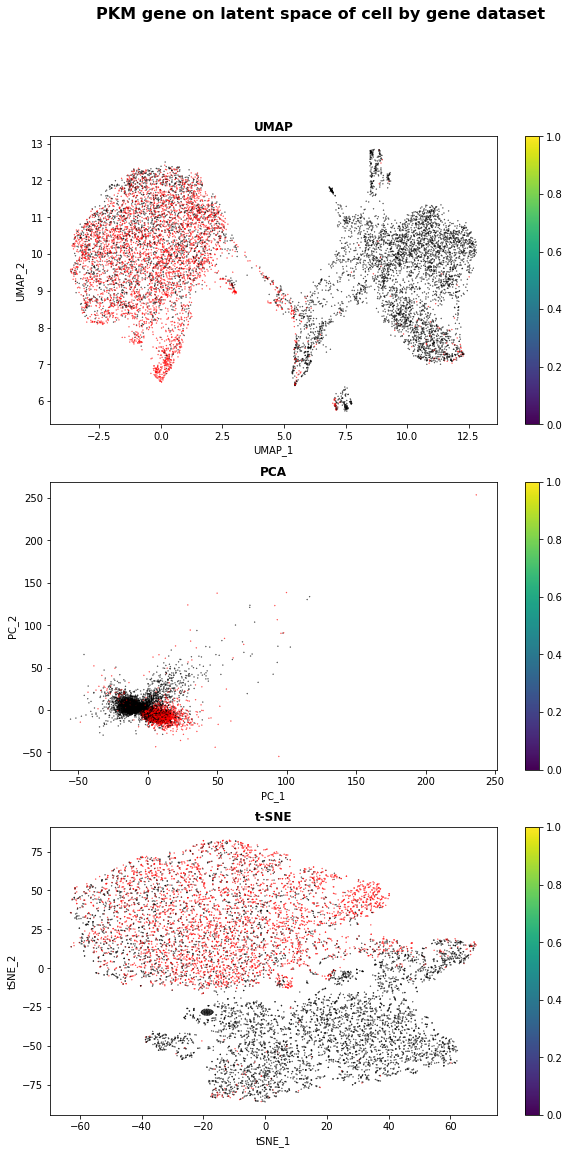

In [51]:
fig, axes = plt.subplots(3,1, figsize=(10,18))
fig.suptitle('PKM gene on latent space of cell by gene dataset', fontsize=16, fontweight="bold")
axes[0].set_title("UMAP", fontweight="bold")
scatter_umap = axes[0].scatter(coordsUMAP[:,0], coordsUMAP[:,1], c=color, cmap='viridis', s=0.1)
fig.colorbar(scatter_umap, ax=axes[0])
axes[0].set_xlabel("UMAP_1")
axes[0].set_ylabel("UMAP_2")

axes[1].set_title("PCA", fontweight="bold")
scatter_pca = axes[1].scatter(coordsPCA[:, 0], coordsPCA[:, 1], c=color, cmap='viridis', s=0.1)
fig.colorbar(scatter_pca, ax=axes[1])
axes[1].set_xlabel("PC_1")
axes[1].set_ylabel("PC_2")

axes[2].set_title("t-SNE", fontweight="bold")
scatter_tsne = axes[2].scatter(coordsTSNE[:, 0], coordsTSNE[:, 1], c=color, cmap='viridis', s=0.1)
fig.colorbar(scatter_tsne, ax=axes[2])
axes[2].set_xlabel("tSNE_1")
axes[2].set_ylabel("tSNE_2")

plt.show()

200.0
4.977655118308793


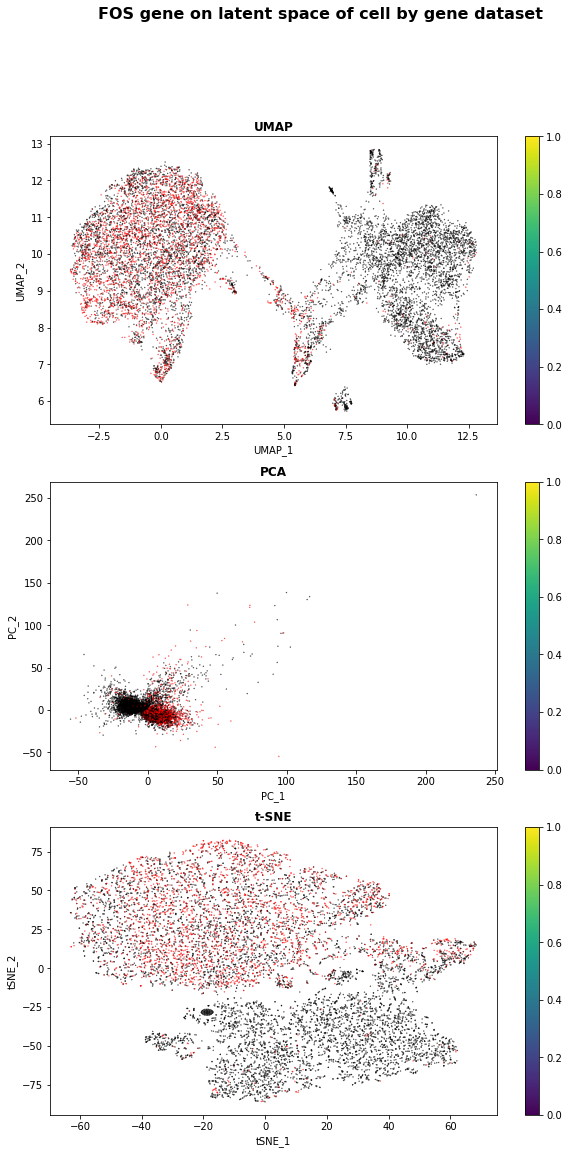

In [52]:
max_FOS = mARN_df['FOS'].max()
mean_FOS = mARN_df['FOS'].mean()
print(max_FOS)
print(mean_FOS)

FOS_expressed = mARN_df[mARN_df['FOS'] > mean_FOS].index
FOS_expressed_test = []

for i, index in enumerate(X_test.indices):
    if index in FOS_expressed:
        FOS_expressed_test.append(i)
        
color_FOS = ['red' if i in FOS_expressed_test else 'black' for i in range(len(X_test))]

fig, axes = plt.subplots(3,1, figsize=(10,18))
fig.suptitle('FOS gene on latent space of cell by gene dataset', fontsize=16, fontweight="bold")
axes[0].set_title("UMAP", fontweight="bold")
scatter_umap = axes[0].scatter(coordsUMAP[:,0], coordsUMAP[:,1], c=color_FOS, cmap='viridis', s=0.1)
fig.colorbar(scatter_umap, ax=axes[0])
axes[0].set_xlabel("UMAP_1")
axes[0].set_ylabel("UMAP_2")

axes[1].set_title("PCA", fontweight="bold")
scatter_pca = axes[1].scatter(coordsPCA[:, 0], coordsPCA[:, 1], c=color_FOS, cmap='viridis', s=0.1)
fig.colorbar(scatter_pca, ax=axes[1])
axes[1].set_xlabel("PC_1")
axes[1].set_ylabel("PC_2")

axes[2].set_title("t-SNE", fontweight="bold")
scatter_tsne = axes[2].scatter(coordsTSNE[:, 0], coordsTSNE[:, 1], c=color_FOS, cmap='viridis', s=0.1)
fig.colorbar(scatter_tsne, ax=axes[2])
axes[2].set_xlabel("tSNE_1")
axes[2].set_ylabel("tSNE_2")

plt.show()

200.0
4.977655118308793


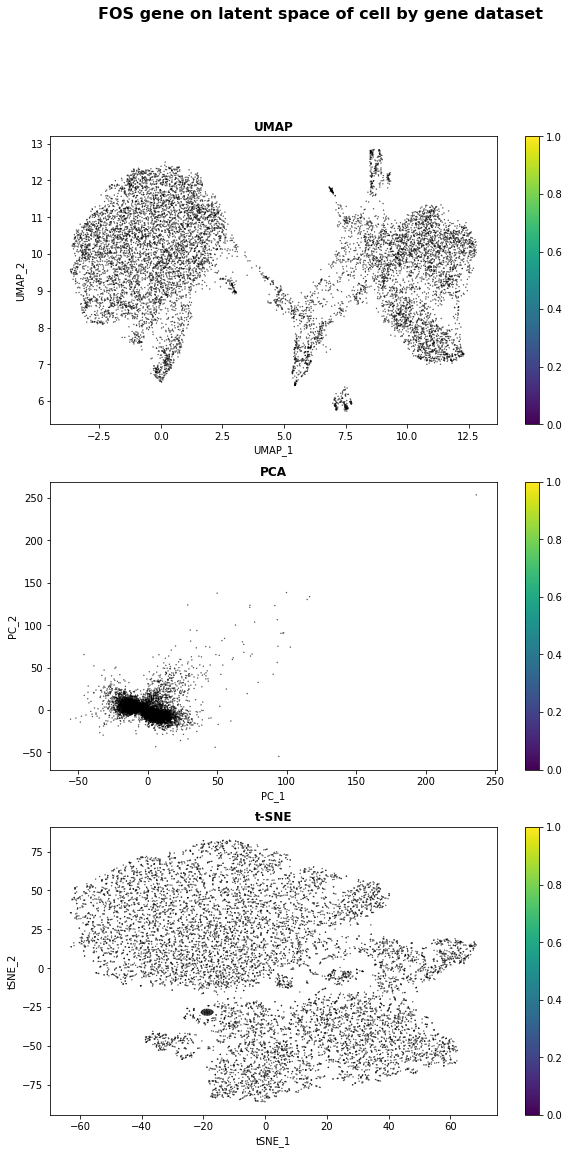

In [53]:
max_CD68 = mARN_df['FOS'].max()
mean_CD68 = mARN_df['FOS'].mean()
print(max_CD68)
print(mean_CD68)

CD68_expressed = mARN_df[mARN_df['CD68'] > mean_CD68].index
CD68_expressed_test = []

for i, index in enumerate(X_test.indices):
    if index in CD68_expressed:
        CD68_expressed_test.append(i)
        
color_CD68 = ['red' if i in CD68_expressed_test else 'black' for i in range(len(X_test))]

fig, axes = plt.subplots(3,1, figsize=(10,18))
fig.suptitle('FOS gene on latent space of cell by gene dataset', fontsize=16, fontweight="bold")
axes[0].set_title("UMAP", fontweight="bold")
scatter_umap = axes[0].scatter(coordsUMAP[:,0], coordsUMAP[:,1], c=color_CD68, cmap='viridis', s=0.1)
fig.colorbar(scatter_umap, ax=axes[0])
axes[0].set_xlabel("UMAP_1")
axes[0].set_ylabel("UMAP_2")

axes[1].set_title("PCA", fontweight="bold")
scatter_pca = axes[1].scatter(coordsPCA[:, 0], coordsPCA[:, 1], c=color_CD68, cmap='viridis', s=0.1)
fig.colorbar(scatter_pca, ax=axes[1])
axes[1].set_xlabel("PC_1")
axes[1].set_ylabel("PC_2")

axes[2].set_title("t-SNE", fontweight="bold")
scatter_tsne = axes[2].scatter(coordsTSNE[:, 0], coordsTSNE[:, 1], c=color_CD68, cmap='viridis', s=0.1)
fig.colorbar(scatter_tsne, ax=axes[2])
axes[2].set_xlabel("tSNE_1")
axes[2].set_ylabel("tSNE_2")

plt.show()